In [2]:

import tensorflow as tf
import numpy as np
import random
import os

In [3]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [4]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [5]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [6]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [7]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_2HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '99.mat')
  X99_normal = scipy.io.loadmat(file_path1)['X099_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

    
  # X111_InnerRace_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/111.mat')['X111_DE_time']
  file_path2 = os.path.join(folder_path, '111.mat')
  X111_InnerRace_007  = scipy.io.loadmat(file_path2)['X111_DE_time']

  # X124_Ball_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/124.mat')['X124_DE_time']
  file_path3 = os.path.join(folder_path, '124.mat')
  X124_Ball_007 = scipy.io.loadmat(file_path3)['X124_DE_time']

  # X137_Outer_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/137.mat')['X137_DE_time']
  file_path4 = os.path.join(folder_path, '137.mat')
  X137_Outer_007 = scipy.io.loadmat(file_path4)['X137_DE_time']
    
  # X176_InnerRace_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/176.mat')['X176_DE_time']
  file_path5 = os.path.join(folder_path, '176.mat')
  X176_InnerRace_014 = scipy.io.loadmat(file_path5)['X176_DE_time']

  # X191_Ball_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/191.mat')['X191_DE_time']
  file_path6 = os.path.join(folder_path, '191.mat')
  X191_Ball_014 = scipy.io.loadmat(file_path6)['X191_DE_time']
    
  # X203_Outer_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/203.mat')['X203_DE_time']
  file_path7 = os.path.join(folder_path, '203.mat')
  X203_Outer_014  = scipy.io.loadmat(file_path7)['X203_DE_time']

  #  X215_InnerRace_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/215.mat')['X215_DE_time']
  file_path8 = os.path.join(folder_path, '215.mat')
  X215_InnerRace_021  = scipy.io.loadmat(file_path8)['X215_DE_time']
    
  # X228_Ball_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/228.mat')['X228_DE_time']
  file_path9 = os.path.join(folder_path, '228.mat')
  X228_Ball_021  = scipy.io.loadmat(file_path9)['X228_DE_time']

  # X240_Outer_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/240.mat')['X240_DE_time']
  file_path10 = os.path.join(folder_path, '240.mat')
  X240_Outer_021  = scipy.io.loadmat(file_path10)['X240_DE_time'] 
    
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]

In [8]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    print(len(Data))
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [9]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

In [10]:
Data = ImportData()
interval_length = 320 #1600  #290 #200  
samples_per_block = 1296 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


485063
485643
486804
486804
487964
487384
486804
491446
487384
487964
[[ 0.06425354  0.06300185 -0.00438092 ... -0.029832   -0.018984
  -0.002712  ]
 [ 0.06571385  0.01606338 -0.05424    ...  0.01585477  0.02211323
   0.07280677]
 [ 0.04672985 -0.00146031 -0.04819015 ... -0.10952308 -0.06884308
   0.00146031]
 ...
 [ 0.13354667  0.09932533  0.06426933 ... -0.00584267  0.06844267
   0.13354667]
 [ 0.13688533  0.11268     0.08430133 ...  0.20365867  0.13855467
   0.06844267]
 [-0.686096   -0.74201867 -0.698616   ... -0.23370667 -0.33136267
  -0.34221333]]
Shape of Input Data = (15179, 1296)
Shape of Label Y_CNN = (15179, 10)
Shape of Label Y = (15179, 1)


In [11]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,36,36,1])

# Input_2D = X_image.reshape([-1,96,96,1])
print(Input_2D.shape)

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(36,36,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

(15179, 36, 36, 1)


In [12]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp4/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-04 14:08:36.211370: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:08:36.212443: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5221 - loss: 1.3004

2025-06-04 14:08:46.794896: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:08:46.795186: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.83738, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5233 - loss: 1.2972 - val_accuracy: 0.8374 - val_loss: 0.3604
Epoch 2/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8560 - loss: 0.3464
Epoch 2: val_accuracy did not improve from 0.83738
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8560 - loss: 0.3463 - val_accuracy: 0.7637 - val_loss: 0.5688
Epoch 3/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8601 - loss: 0.3260
Epoch 3: val_accuracy did not improve from 0.83738
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8602 - loss: 0.3257 - val_accuracy: 0.8024 - val_loss: 0.4405
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8811 - loss: 0.2536
Epoch 4: val_accuracy did not improve from 0.83738
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8811 - loss: 0.2535 - val_accuracy: 0.7929 - val_loss: 0.4992
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8904 - loss: 0.2537
Epoch 5: val_accura

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8905 - loss: 0.2535 - val_accuracy: 0.8860 - val_loss: 0.2393
Epoch 6/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9120 - loss: 0.1914
Epoch 6: val_accuracy improved from 0.88596 to 0.88925, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9121 - loss: 0.1913 - val_accuracy: 0.8893 - val_loss: 0.2468
Epoch 7/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9083 - loss: 0.2124
Epoch 7: val_accuracy improved from 0.88925 to 0.90737, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9084 - loss: 0.2123 - val_accuracy: 0.9074 - val_loss: 0.2068
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9330 - loss: 0.1622
Epoch 8: val_accuracy improved from 0.90737 to 0.94195, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9330 - loss: 0.1621 - val_accuracy: 0.9420 - val_loss: 0.1514
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9409 - loss: 0.1509
Epoch 9: val_accuracy improved from 0.94195 to 0.94977, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9410 - loss: 0.1508 - val_accuracy: 0.9498 - val_loss: 0.1179
Epoch 10/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9523 - loss: 0.1221
Epoch 10: val_accuracy improved from 0.94977 to 0.96418, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9524 - loss: 0.1218 - val_accuracy: 0.9642 - val_loss: 0.0912
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9645 - loss: 0.0882
Epoch 11: val_accuracy improved from 0.96418 to 0.97242, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9645 - loss: 0.0881 - val_accuracy: 0.9724 - val_loss: 0.0735
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9661 - loss: 0.0878
Epoch 12: val_accuracy improved from 0.97242 to 0.98106, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9661 - loss: 0.0876 - val_accuracy: 0.9811 - val_loss: 0.0549
Epoch 13/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9688 - loss: 0.0915
Epoch 13: val_accuracy did not improve from 0.98106
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9689 - loss: 0.0913 - val_accuracy: 0.9716 - val_loss: 0.0682
Epoch 14/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9764 - loss: 0.0719
Epoch 14: val_accuracy did not improve from 0.98106
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9764 - loss: 0.0717 - val_accuracy: 0.9741 - val_loss: 0.0663
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9853 - loss: 0.0465
Epoch 15: val_accuracy did not improve from 0.98106
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9853 - loss: 0.0464 - val_accuracy: 0.9807 - val_loss: 0.0582
Epoch 16/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9799 - loss: 0.0586
Epoch 16: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9895 - loss: 0.0273 - val_accuracy: 0.9844 - val_loss: 0.0481
Epoch 23/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9948 - loss: 0.0196
Epoch 23: val_accuracy did not improve from 0.98436
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9948 - loss: 0.0197 - val_accuracy: 0.9687 - val_loss: 0.0896
Epoch 24/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9922 - loss: 0.0287
Epoch 24: val_accuracy did not improve from 0.98436
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9922 - loss: 0.0286 - val_accuracy: 0.9774 - val_loss: 0.0773
Epoch 25/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9892 - loss: 0.0377
Epoch 25: val_accuracy did not improve from 0.98436
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9892 - loss: 0.0376 - val_accuracy: 0.9506 - val_loss: 0.1657
Epoch 26/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9926 - loss: 0.0217
Epoch 26: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9909 - val_loss: 0.0299
Epoch 28/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9998 - loss: 7.2726e-04
Epoch 28: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9998 - loss: 7.4119e-04 - val_accuracy: 0.9864 - val_loss: 0.0433
Epoch 29/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9923 - loss: 0.0222
Epoch 29: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9923 - loss: 0.0223 - val_accuracy: 0.9720 - val_loss: 0.0986
Epoch 30/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9913 - loss: 0.0228
Epoch 30: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9914 - loss: 0.0228 - val_accuracy: 0.9802 - val_loss: 0.0652
Epoch 31/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9915 - loss: 0.0300
Epoch

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 2.1971e-04 - val_accuracy: 0.9914 - val_loss: 0.0319
Epoch 36/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 8.2430e-05
Epoch 36: val_accuracy did not improve from 0.99135
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 8.2413e-05 - val_accuracy: 0.9914 - val_loss: 0.0322
Epoch 37/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 5.5080e-05
Epoch 37: val_accuracy did not improve from 0.99135
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 1.0000 - loss: 5.5073e-05 - val_accuracy: 0.9914 - val_loss: 0.0330
Epoch 38/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 3.9560e-05
Epoch 38: val_accuracy did not improve from 0.99135
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 3.9557e-05 - val_accuracy: 0.9914 - val_loss: 0.0337
Epoch 39/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000

304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 6.1789e-06 - val_accuracy: 0.9918 - val_loss: 0.0391
Epoch 47/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 5.0747e-06
Epoch 47: val_accuracy did not improve from 0.99177
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 5.0756e-06 - val_accuracy: 0.9918 - val_loss: 0.0398
Epoch 48/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 4.1881e-06
Epoch 48: val_accuracy did not improve from 0.99177
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 4.1885e-06 - val_accuracy: 0.9918 - val_loss: 0.0404
Epoch 49/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 3.4647e-06
Epoch 49: val_accuracy did not improve from 0.99177
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 3.4655e-06 - val_accuracy: 0.9918 - val_loss: 0.0410
Epoch 50/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 1.7873e-09 - val_accuracy: 0.9922 - val_loss: 0.0642
Epoch 95/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.4784e-09
Epoch 95: val_accuracy did not improve from 0.99218
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 1.4801e-09 - val_accuracy: 0.9918 - val_loss: 0.0648
Epoch 96/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 1.2088e-09
Epoch 96: val_accuracy did not improve from 0.99218
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 1.2103e-09 - val_accuracy: 0.9922 - val_loss: 0.0650
Epoch 97/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.0635e-09
Epoch 97: val_accuracy did not improve from 0.99218
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 1.0658e-09 - val_accuracy: 0.9922 - val_loss: 0.0651
Epoch 98/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 1.6739e-10 - val_accuracy: 0.9926 - val_loss: 0.0641
Epoch 113/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.8828e-10
Epoch 113: val_accuracy did not improve from 0.99259
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 1.8842e-10 - val_accuracy: 0.9926 - val_loss: 0.0635
Epoch 114/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.6665e-10
Epoch 114: val_accuracy did not improve from 0.99259
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 1.6701e-10 - val_accuracy: 0.9926 - val_loss: 0.0646
Epoch 115/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.8466e-10
Epoch 115: val_accuracy did not improve from 0.99259
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 1.8498e-10 - val_accuracy: 0.9926 - val_loss: 0.0626
Epoch 116/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0

Best model loaded successfully!
14/76 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2025-06-04 14:38:35.621542: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 14:38:35.622417: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.8569e-10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9939 - loss: 0.0478
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9919 - loss: 0.0617
Epoch 1/200


2025-06-04 14:38:41.172659: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:38:41.173005: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5031 - loss: 1.2959

2025-06-04 14:38:50.856476: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:38:50.856776: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.85056, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5050 - loss: 1.2911 - val_accuracy: 0.8506 - val_loss: 0.3511
Epoch 2/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8441 - loss: 0.3597
Epoch 2: val_accuracy improved from 0.85056 to 0.87196, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8441 - loss: 0.3596 - val_accuracy: 0.8720 - val_loss: 0.2884
Epoch 3/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8731 - loss: 0.2855
Epoch 3: val_accuracy improved from 0.87196 to 0.89090, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8731 - loss: 0.2854 - val_accuracy: 0.8909 - val_loss: 0.2369
Epoch 4/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8797 - loss: 0.2631
Epoch 4: val_accuracy improved from 0.89090 to 0.89708, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8797 - loss: 0.2631 - val_accuracy: 0.8971 - val_loss: 0.2377
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9034 - loss: 0.2172
Epoch 5: val_accuracy improved from 0.89708 to 0.90613, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9034 - loss: 0.2173 - val_accuracy: 0.9061 - val_loss: 0.2193
Epoch 6/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9106 - loss: 0.1985
Epoch 6: val_accuracy improved from 0.90613 to 0.92837, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9107 - loss: 0.1985 - val_accuracy: 0.9284 - val_loss: 0.1574
Epoch 7/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9293 - loss: 0.1636
Epoch 7: val_accuracy did not improve from 0.92837
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9293 - loss: 0.1636 - val_accuracy: 0.9057 - val_loss: 0.2968
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9276 - loss: 0.1819
Epoch 8: val_accuracy improved from 0.92837 to 0.93207, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9277 - loss: 0.1818 - val_accuracy: 0.9321 - val_loss: 0.1390
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9536 - loss: 0.1191
Epoch 9: val_accuracy did not improve from 0.93207
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9536 - loss: 0.1190 - val_accuracy: 0.9300 - val_loss: 0.1640
Epoch 10/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9618 - loss: 0.0972
Epoch 10: val_accuracy improved from 0.93207 to 0.93495, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9618 - loss: 0.0972 - val_accuracy: 0.9350 - val_loss: 0.1700
Epoch 11/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9678 - loss: 0.0754
Epoch 11: val_accuracy improved from 0.93495 to 0.93536, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9679 - loss: 0.0753 - val_accuracy: 0.9354 - val_loss: 0.1645
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9704 - loss: 0.0731
Epoch 12: val_accuracy improved from 0.93536 to 0.94072, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9704 - loss: 0.0730 - val_accuracy: 0.9407 - val_loss: 0.1577
Epoch 13/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9783 - loss: 0.0547
Epoch 13: val_accuracy improved from 0.94072 to 0.94195, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9783 - loss: 0.0547 - val_accuracy: 0.9420 - val_loss: 0.1562
Epoch 14/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9813 - loss: 0.0511
Epoch 14: val_accuracy improved from 0.94195 to 0.96624, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9813 - loss: 0.0513 - val_accuracy: 0.9662 - val_loss: 0.0866
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9856 - loss: 0.0437
Epoch 15: val_accuracy did not improve from 0.96624
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9856 - loss: 0.0437 - val_accuracy: 0.9625 - val_loss: 0.1146
Epoch 16/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9880 - loss: 0.0345
Epoch 16: val_accuracy improved from 0.96624 to 0.97859, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9880 - loss: 0.0345 - val_accuracy: 0.9786 - val_loss: 0.0624
Epoch 17/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9858 - loss: 0.0436
Epoch 17: val_accuracy improved from 0.97859 to 0.98147, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9858 - loss: 0.0436 - val_accuracy: 0.9815 - val_loss: 0.0624
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9843 - loss: 0.0403
Epoch 18: val_accuracy did not improve from 0.98147
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9843 - loss: 0.0403 - val_accuracy: 0.9699 - val_loss: 0.0916
Epoch 19/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9843 - loss: 0.0403
Epoch 19: val_accuracy improved from 0.98147 to 0.98806, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9844 - loss: 0.0402 - val_accuracy: 0.9881 - val_loss: 0.0396
Epoch 20/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9824 - loss: 0.0594
Epoch 20: val_accuracy did not improve from 0.98806
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9824 - loss: 0.0594 - val_accuracy: 0.9765 - val_loss: 0.0737
Epoch 21/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9948 - loss: 0.0179
Epoch 21: val_accuracy did not improve from 0.98806
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9948 - loss: 0.0179 - val_accuracy: 0.9728 - val_loss: 0.0963
Epoch 22/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9909 - loss: 0.0250
Epoch 22: val_accuracy did not improve from 0.98806
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9909 - loss: 0.0250 - val_accuracy: 0.9852 - val_loss: 0.0443
Epoch 23/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9896 - loss: 0.0336
Epoch 23: val

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9958 - loss: 0.0107 - val_accuracy: 0.9889 - val_loss: 0.0400
Epoch 28/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9963 - loss: 0.0144
Epoch 28: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9963 - loss: 0.0144 - val_accuracy: 0.9753 - val_loss: 0.0844
Epoch 29/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9952 - loss: 0.0154
Epoch 29: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9952 - loss: 0.0153 - val_accuracy: 0.9502 - val_loss: 0.2101
Epoch 30/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9977 - loss: 0.0057
Epoch 30: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9977 - loss: 0.0057 - val_accuracy: 0.9835 - val_loss: 0.0646
Epoch 31/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9942 - loss: 0.0169
Epoch 31: va

Best model saved at: CNN2D_results/V4_2_NOL_exp2/best_model_2.h5
Best model loaded successfully!
14/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2025-06-04 14:50:51.427817: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 14:50:51.428652: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9988 - loss: 0.0034
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9889 - loss: 0.0393
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9846 - loss: 0.0396
Epoch 1/200


2025-06-04 14:50:56.656322: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:50:56.656608: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4881 - loss: 1.3582

2025-06-04 14:51:07.402412: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 14:51:07.402714: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.81103, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4894 - loss: 1.3550 - val_accuracy: 0.8110 - val_loss: 0.4865
Epoch 2/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8089 - loss: 0.4314
Epoch 2: val_accuracy improved from 0.81103 to 0.84315, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8091 - loss: 0.4311 - val_accuracy: 0.8431 - val_loss: 0.3806
Epoch 3/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8559 - loss: 0.3127
Epoch 3: val_accuracy did not improve from 0.84315
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8560 - loss: 0.3125 - val_accuracy: 0.8275 - val_loss: 0.4066
Epoch 4/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8752 - loss: 0.2614
Epoch 4: val_accuracy improved from 0.84315 to 0.86291, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8752 - loss: 0.2613 - val_accuracy: 0.8629 - val_loss: 0.3255
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8883 - loss: 0.2336
Epoch 5: val_accuracy improved from 0.86291 to 0.88843, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8883 - loss: 0.2337 - val_accuracy: 0.8884 - val_loss: 0.2386
Epoch 6/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9044 - loss: 0.2012
Epoch 6: val_accuracy improved from 0.88843 to 0.91807, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9044 - loss: 0.2011 - val_accuracy: 0.9181 - val_loss: 0.1959
Epoch 7/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9144 - loss: 0.1882
Epoch 7: val_accuracy improved from 0.91807 to 0.91848, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9145 - loss: 0.1881 - val_accuracy: 0.9185 - val_loss: 0.2219
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9296 - loss: 0.1602
Epoch 8: val_accuracy improved from 0.91848 to 0.95389, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9297 - loss: 0.1601 - val_accuracy: 0.9539 - val_loss: 0.1224
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9348 - loss: 0.1510
Epoch 9: val_accuracy improved from 0.95389 to 0.96212, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9348 - loss: 0.1509 - val_accuracy: 0.9621 - val_loss: 0.1137
Epoch 10/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9548 - loss: 0.1129
Epoch 10: val_accuracy did not improve from 0.96212
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9549 - loss: 0.1128 - val_accuracy: 0.9555 - val_loss: 0.1176
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9597 - loss: 0.1080
Epoch 11: val_accuracy did not improve from 0.96212
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9597 - loss: 0.1079 - val_accuracy: 0.9494 - val_loss: 0.1557
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9652 - loss: 0.0893
Epoch 12: val_accuracy did not improve from 0.96212
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9652 - loss: 0.0893 - val_accuracy: 0.9551 - val_loss: 0.1115
Epoch 13/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9821 - loss: 0.0484
Epoch 13: val_ac

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9822 - loss: 0.0484 - val_accuracy: 0.9699 - val_loss: 0.0762
Epoch 14/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9886 - loss: 0.0373
Epoch 14: val_accuracy improved from 0.96995 to 0.97736, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9886 - loss: 0.0373 - val_accuracy: 0.9774 - val_loss: 0.0754
Epoch 15/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9864 - loss: 0.0430
Epoch 15: val_accuracy did not improve from 0.97736
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9865 - loss: 0.0429 - val_accuracy: 0.9741 - val_loss: 0.0797
Epoch 16/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9886 - loss: 0.0335
Epoch 16: val_accuracy did not improve from 0.97736
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9886 - loss: 0.0336 - val_accuracy: 0.9592 - val_loss: 0.1269
Epoch 17/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9791 - loss: 0.0680
Epoch 17: val_accuracy did not improve from 0.97736
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9791 - loss: 0.0679 - val_accuracy: 0.9732 - val_loss: 0.0735
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9872 - loss: 0.0360
Epoch 18: val_ac

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9960 - loss: 0.0135 - val_accuracy: 0.9852 - val_loss: 0.0540
Epoch 26/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9923 - loss: 0.0187
Epoch 26: val_accuracy did not improve from 0.98518
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9924 - loss: 0.0187 - val_accuracy: 0.9827 - val_loss: 0.0696
Epoch 27/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9978 - loss: 0.0076
Epoch 27: val_accuracy did not improve from 0.98518
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9978 - loss: 0.0076 - val_accuracy: 0.9848 - val_loss: 0.0632
Epoch 28/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 8.8036e-04
Epoch 28: val_accuracy did not improve from 0.98518
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 8.7611e-04 - val_accuracy: 0.9815 - val_loss: 0.0804
Epoch 29/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 3.0021e-04
Ep

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 1.0000 - loss: 2.9935e-04 - val_accuracy: 0.9856 - val_loss: 0.0637
Epoch 30/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 1.0513e-04
Epoch 30: val_accuracy did not improve from 0.98559
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 1.0500e-04 - val_accuracy: 0.9852 - val_loss: 0.0650
Epoch 31/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 8.0279e-05
Epoch 31: val_accuracy did not improve from 0.98559
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 8.0237e-05 - val_accuracy: 0.9844 - val_loss: 0.0668
Epoch 32/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 5.0299e-05
Epoch 32: val_accuracy did not improve from 0.98559
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 5.0263e-05 - val_accuracy: 0.9844 - val_loss: 0.0688
Epoch 33/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - 

304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 3.5926e-07 - val_accuracy: 0.9860 - val_loss: 0.1051
Epoch 59/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 3.0382e-07
Epoch 59: val_accuracy did not improve from 0.98600
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 3.0365e-07 - val_accuracy: 0.9860 - val_loss: 0.1065
Epoch 60/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 2.5468e-07
Epoch 60: val_accuracy did not improve from 0.98600
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 2.5454e-07 - val_accuracy: 0.9860 - val_loss: 0.1080
Epoch 61/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 2.1459e-07
Epoch 61: val_accuracy did not improve from 0.98600
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 2.1447e-07 - val_accuracy: 0.9860 - val_loss: 0.1094
Epoch 62/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - 

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 1.0000 - loss: 1.1598e-09 - val_accuracy: 0.9864 - val_loss: 0.1446
Epoch 95/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.0541e-09
Epoch 95: val_accuracy did not improve from 0.98641
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 1.0529e-09 - val_accuracy: 0.9864 - val_loss: 0.1446
Epoch 96/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 1.0000 - loss: 7.7640e-10
Epoch 96: val_accuracy did not improve from 0.98641
304/304 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 1.0000 - loss: 7.7646e-10 - val_accuracy: 0.9860 - val_loss: 0.1450
Epoch 97/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 7.0430e-10
Epoch 97: val_accuracy did not improve from 0.98641
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 7.0438e-10 - val_accuracy: 0.9860 - val_loss: 0.1451
Epoch 98/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - l

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9872 - val_loss: 0.0712
Epoch 116/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 1.8925e-04
Epoch 116: val_accuracy did not improve from 0.98724
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 1.8904e-04 - val_accuracy: 0.9864 - val_loss: 0.0731
Epoch 117/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 1.1738e-04
Epoch 117: val_accuracy did not improve from 0.98724
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 1.1734e-04 - val_accuracy: 0.9868 - val_loss: 0.0758
Epoch 118/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 8.5343e-05
Epoch 118: val_accuracy did not improve from 0.98724
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 8.5328e-05 - val_accuracy: 0.9868 - val_loss: 0.0782
Epoch 119/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 5.8851e-07 - val_accuracy: 0.9876 - val_loss: 0.1251
Epoch 145/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 4.9530e-07
Epoch 145: val_accuracy improved from 0.98765 to 0.98806, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 1.0000 - loss: 4.9512e-07 - val_accuracy: 0.9881 - val_loss: 0.1268
Epoch 146/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 4.1718e-07
Epoch 146: val_accuracy did not improve from 0.98806
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 4.1702e-07 - val_accuracy: 0.9881 - val_loss: 0.1290
Epoch 147/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 3.5163e-07
Epoch 147: val_accuracy did not improve from 0.98806
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 3.5143e-07 - val_accuracy: 0.9876 - val_loss: 0.1308
Epoch 148/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 2.9562e-07
Epoch 148: val_accuracy did not improve from 0.98806
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 1.0000 - loss: 2.9551e-07 - val_accuracy: 0.9876 - val_loss: 0.1326
Epoch 149/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.

Best model saved at: CNN2D_results/V4_2_NOL_exp2/best_model_3.h5
Best model loaded successfully!
 6/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step  

2025-06-04 15:35:52.817054: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 15:35:52.818237: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 3.2096e-07
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9918 - loss: 0.1043
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9883 - loss: 0.0526
Epoch 1/200


2025-06-04 15:35:57.982874: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 15:35:57.983165: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4912 - loss: 1.3278

2025-06-04 15:36:07.483527: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 15:36:07.483801: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.80560, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4930 - loss: 1.3231 - val_accuracy: 0.8056 - val_loss: 0.4548
Epoch 2/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.3983
Epoch 2: val_accuracy improved from 0.80560 to 0.82372, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8400 - loss: 0.3982 - val_accuracy: 0.8237 - val_loss: 0.3860
Epoch 3/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8743 - loss: 0.2925
Epoch 3: val_accuracy improved from 0.82372 to 0.88015, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8743 - loss: 0.2925 - val_accuracy: 0.8801 - val_loss: 0.2650
Epoch 4/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8987 - loss: 0.2395
Epoch 4: val_accuracy improved from 0.88015 to 0.88591, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8987 - loss: 0.2395 - val_accuracy: 0.8859 - val_loss: 0.2213
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9117 - loss: 0.1900
Epoch 5: val_accuracy improved from 0.88591 to 0.91351, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9117 - loss: 0.1901 - val_accuracy: 0.9135 - val_loss: 0.1818
Epoch 6/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9184 - loss: 0.1836
Epoch 6: val_accuracy improved from 0.91351 to 0.92051, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9184 - loss: 0.1836 - val_accuracy: 0.9205 - val_loss: 0.1760
Epoch 7/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9351 - loss: 0.1424
Epoch 7: val_accuracy did not improve from 0.92051
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9350 - loss: 0.1426 - val_accuracy: 0.8999 - val_loss: 0.2633
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9405 - loss: 0.1386
Epoch 8: val_accuracy improved from 0.92051 to 0.95593, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9405 - loss: 0.1385 - val_accuracy: 0.9559 - val_loss: 0.1120
Epoch 9/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9665 - loss: 0.0859
Epoch 9: val_accuracy improved from 0.95593 to 0.96993, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9665 - loss: 0.0860 - val_accuracy: 0.9699 - val_loss: 0.0863
Epoch 10/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9693 - loss: 0.0856
Epoch 10: val_accuracy did not improve from 0.96993
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9693 - loss: 0.0857 - val_accuracy: 0.9605 - val_loss: 0.1060
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9637 - loss: 0.0927
Epoch 11: val_accuracy did not improve from 0.96993
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9637 - loss: 0.0927 - val_accuracy: 0.9230 - val_loss: 0.2543
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9701 - loss: 0.0818
Epoch 12: val_accuracy did not improve from 0.96993
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9701 - loss: 0.0817 - val_accuracy: 0.9514 - val_loss: 0.1154
Epoch 13/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9806 - loss: 0.0541
Epoch 13: val_a

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9895 - loss: 0.0284 - val_accuracy: 0.9848 - val_loss: 0.0495
Epoch 17/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9953 - loss: 0.0157
Epoch 17: val_accuracy improved from 0.98476 to 0.98929, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9953 - loss: 0.0157 - val_accuracy: 0.9893 - val_loss: 0.0404
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9945 - loss: 0.0172
Epoch 18: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9944 - loss: 0.0173 - val_accuracy: 0.9778 - val_loss: 0.0629
Epoch 19/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9934 - loss: 0.0190
Epoch 19: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9934 - loss: 0.0191 - val_accuracy: 0.9782 - val_loss: 0.0635
Epoch 20/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9916 - loss: 0.0212
Epoch 20: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9916 - loss: 0.0213 - val_accuracy: 0.9086 - val_loss: 0.3291
Epoch 21/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9790 - loss: 0.0602
Epoch 21: val_ac

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9970 - loss: 0.0074 - val_accuracy: 0.9905 - val_loss: 0.0399
Epoch 26/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 7.5800e-04
Epoch 26: val_accuracy improved from 0.99053 to 0.99094, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 1.0000 - loss: 7.5700e-04 - val_accuracy: 0.9909 - val_loss: 0.0395
Epoch 27/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9997 - loss: 9.2415e-04
Epoch 27: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9997 - loss: 9.2747e-04 - val_accuracy: 0.9897 - val_loss: 0.0462
Epoch 28/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9970 - loss: 0.0118
Epoch 28: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9969 - loss: 0.0120 - val_accuracy: 0.9671 - val_loss: 0.1132
Epoch 29/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9908 - loss: 0.0272
Epoch 29: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9908 - loss: 0.0272 - val_accuracy: 0.9786 - val_loss: 0.0696
Epoch 30/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9930 - loss: 0.0268
Epo

Best model saved at: CNN2D_results/V4_2_NOL_exp2/best_model_4.h5
Best model loaded successfully!
15/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2025-06-04 15:47:56.470985: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 15:47:56.471928: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 1.9121e-04
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9930 - loss: 0.0322
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9939 - loss: 0.0203
Epoch 1/200


2025-06-04 15:48:01.525640: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 15:48:01.525907: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5150 - loss: 1.2869

2025-06-04 15:48:11.056325: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-04 15:48:11.056631: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.84061, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5162 - loss: 1.2837 - val_accuracy: 0.8406 - val_loss: 0.3526
Epoch 2/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8334 - loss: 0.3725
Epoch 2: val_accuracy improved from 0.84061 to 0.84185, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8335 - loss: 0.3723 - val_accuracy: 0.8418 - val_loss: 0.3699
Epoch 3/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8611 - loss: 0.2907
Epoch 3: val_accuracy did not improve from 0.84185
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8612 - loss: 0.2906 - val_accuracy: 0.7722 - val_loss: 0.8246
Epoch 4/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8803 - loss: 0.2500
Epoch 4: val_accuracy did not improve from 0.84185
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8804 - loss: 0.2499 - val_accuracy: 0.8344 - val_loss: 0.4494
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8984 - loss: 0.2132
Epoch 5: val_accuracy did not improve from 0.84185
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8985 - loss: 0.2131 - val_accuracy: 0.8089 - val_loss: 0.5037
Epoch 6/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9165 - loss: 0.1979
Epoch 6: val_accura

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9166 - loss: 0.1978 - val_accuracy: 0.9399 - val_loss: 0.1556
Epoch 7/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9361 - loss: 0.1682
Epoch 7: val_accuracy improved from 0.93987 to 0.94357, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9362 - loss: 0.1681 - val_accuracy: 0.9436 - val_loss: 0.1404
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9528 - loss: 0.1132
Epoch 8: val_accuracy improved from 0.94357 to 0.94852, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9528 - loss: 0.1132 - val_accuracy: 0.9485 - val_loss: 0.1449
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9595 - loss: 0.1056
Epoch 9: val_accuracy did not improve from 0.94852
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9595 - loss: 0.1056 - val_accuracy: 0.9473 - val_loss: 0.1589
Epoch 10/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9642 - loss: 0.1030
Epoch 10: val_accuracy did not improve from 0.94852
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9642 - loss: 0.1029 - val_accuracy: 0.9287 - val_loss: 0.1784
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9714 - loss: 0.0721
Epoch 11: val_accuracy did not improve from 0.94852
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9714 - loss: 0.0721 - val_accuracy: 0.9432 - val_loss: 0.1429
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9757 - loss: 0.0711
Epoch 12: val_ac

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9788 - loss: 0.0623 - val_accuracy: 0.9753 - val_loss: 0.0628
Epoch 14/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9846 - loss: 0.0444
Epoch 14: val_accuracy did not improve from 0.97529
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9846 - loss: 0.0444 - val_accuracy: 0.9419 - val_loss: 0.1708
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9744 - loss: 0.0668
Epoch 15: val_accuracy improved from 0.97529 to 0.97858, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9744 - loss: 0.0667 - val_accuracy: 0.9786 - val_loss: 0.0564
Epoch 16/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9832 - loss: 0.0502
Epoch 16: val_accuracy did not improve from 0.97858
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9832 - loss: 0.0503 - val_accuracy: 0.9720 - val_loss: 0.0828
Epoch 17/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9869 - loss: 0.0440
Epoch 17: val_accuracy did not improve from 0.97858
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9869 - loss: 0.0439 - val_accuracy: 0.9629 - val_loss: 0.1109
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9940 - loss: 0.0160
Epoch 18: val_accuracy did not improve from 0.97858
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9940 - loss: 0.0160 - val_accuracy: 0.9559 - val_loss: 0.1540
Epoch 19/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9832 - loss: 0.0496
Epoch 19: val_ac

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9892 - loss: 0.0314 - val_accuracy: 0.9794 - val_loss: 0.0646
Epoch 21/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9918 - loss: 0.0273
Epoch 21: val_accuracy improved from 0.97941 to 0.98847, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9918 - loss: 0.0273 - val_accuracy: 0.9885 - val_loss: 0.0424
Epoch 22/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9964 - loss: 0.0101
Epoch 22: val_accuracy did not improve from 0.98847
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9964 - loss: 0.0101 - val_accuracy: 0.9419 - val_loss: 0.2324
Epoch 23/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9917 - loss: 0.0200
Epoch 23: val_accuracy did not improve from 0.98847
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9917 - loss: 0.0201 - val_accuracy: 0.9773 - val_loss: 0.0781
Epoch 24/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9892 - loss: 0.0358
Epoch 24: val_accuracy did not improve from 0.98847
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9892 - loss: 0.0357 - val_accuracy: 0.9584 - val_loss: 0.1647
Epoch 25/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9707 - loss: 0.0947
Epoch 25: val_a

304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9889 - val_loss: 0.0461
Epoch 33/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9956 - loss: 0.0132
Epoch 33: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9956 - loss: 0.0132 - val_accuracy: 0.9889 - val_loss: 0.0445
Epoch 34/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 4.6221e-04
Epoch 34: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 4.6182e-04 - val_accuracy: 0.9881 - val_loss: 0.0478
Epoch 35/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.0200e-04
Epoch 35: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 1.0000 - loss: 1.0199e-04 - val_accuracy: 0.9872 - val_loss: 0.0453
Epoch 36/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 6.0233e

Best model saved at: CNN2D_results/V4_2_NOL_exp2/best_model_5.h5
Best model loaded successfully!


2025-06-04 16:00:51.972013: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-04 16:00:51.973276: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 4.5796e-04
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9914 - loss: 0.0378
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9918 - loss: 0.0337


CNN 2D train accuracy = 99.98147010803223
CNN 2D validation accuracy = 98.98707151412964
CNN 2D test accuracy = 99.00527000427246
 14/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

2025-06-05 09:25:41.973738: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 09:25:41.974607: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


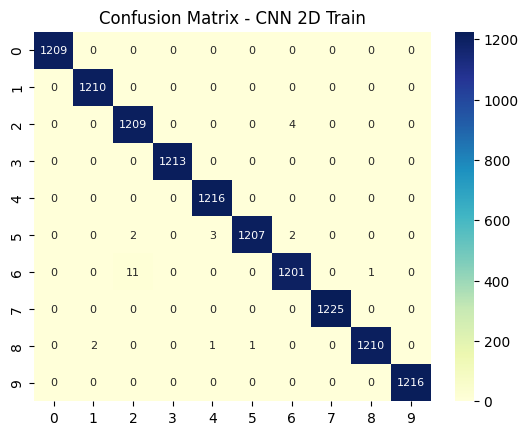

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


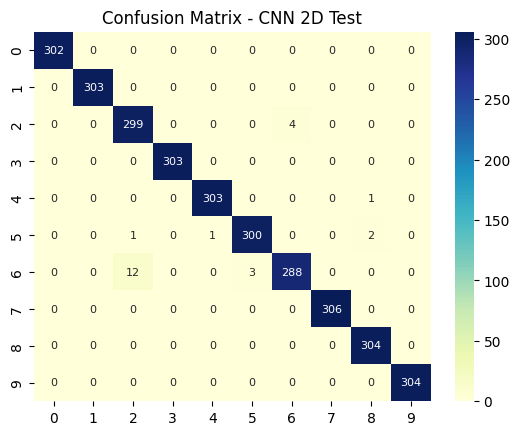

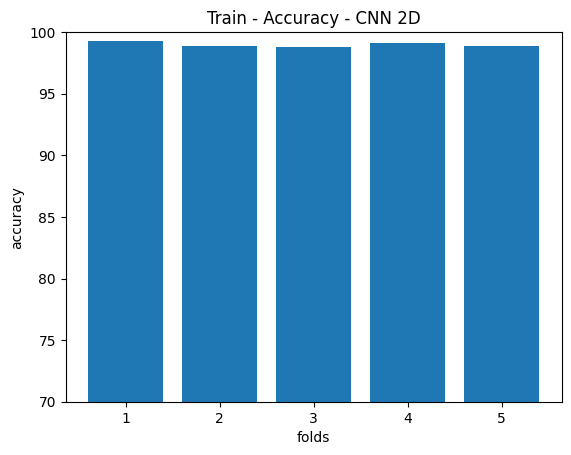

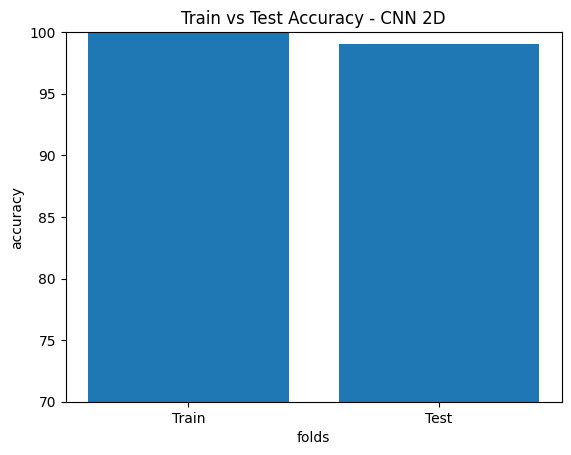

In [14]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

In [22]:
from tensorflow.keras.models import load_model

# for i in range(1, 6):
#     filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_{i}.h5"
#     print(f"\nModel summary for fold {i}:")
#     model = load_model(filepath)
#     model.summary()
#     for i, layer in enumerate(model.layers):
#         print(f"{i}: {layer.name} — {layer.output_shape}")


filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_1.h5"
print(f"\nModel summary for fold 1:")
model = load_model(filepath)
model.summary()
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")


layer_name = 'dense'  # or whatever corresponds to Dense(100)
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)



Model summary for fold 1:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 40, 40, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_5 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,014 (851.62 KB)

 Trainable params: 218,012 (851.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

0: conv2d_20
1: max_pooling2d_20
2: conv2d_21
3: max_pooling2d_21
4: conv2d_22
5: max_pooling2d_22
6: conv2d_23
7: max_pooling2d_23
8: flatten_5
9: dense_15
10: dense_16
11: dense_17
12: softmax_5


AttributeError: The layer sequential_5 has never been called and thus has no defined input.

In [ ]:
# Step 1: Sample training inputs (every 10th) and get intermediate outputs
x_sampled = X_2D_train[::10]
y_sampled = y_2D_train[::10]

intermediate_outputs = intermediate_model.predict(x_sampled)

# Step 2: Reduce dimensionality using t-SNE
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(intermediate_outputs)

# Step 3: Decode one-hot labels (if needed)
from sklearn.preprocessing import LabelEncoder
if y_sampled.shape[1] > 1:
    y_label = enc.inverse_transform(y_sampled)
else:
    y_label = y_sampled.flatten()

# Step 4: Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label, style=y_label,
                palette="bright", edgecolor='black')
plt.title("t-SNE of Intermediate CNN Layer Output (Fold 1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
